## Libraries

In [59]:
# Supress warnings
import warnings; warnings.filterwarnings('ignore')

# Data and math operations
import re
from math import hypot
import numpy as np
import pandas as pd

# Image processing
import cv2
import mediapipe as mp

# Image visualizations
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Audio Speech
import pyttsx3

# For opening images via URL
from PIL.Image import open as open_image
from urllib.request import urlopen

# Display images in Jupyter Notebook
from IPython.display import Image

# macOS alternative to pycaw
import osascript

# Control the reality and flow of time
import os
import time

How to use `osascript`:
```
# Set desired volume
VOLUME = 50
# Create string (used in AppleScript)
volume_str = "set volume output volume " + str(VOLUME)
# Apply changes
osascript.osascript(volume_str)
# Get current volume level
volume_str = osascript.osascript('get volume settings')
````

## Defines

In [60]:
# mediapipe instances
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

# Landmark styles
HAND_CONNECTIONS = mp_hands.HAND_CONNECTIONS
DEFAULT_LANDMARK_POINTS = mp_drawing_styles.get_default_hand_landmarks_style()
DEFAULT_LANDMARK_CONNECTIONS = mp_drawing_styles.get_default_hand_connections_style()
BASIC_LANDMARK_POINTS_SPEC = mp_drawing.DrawingSpec(color=(22,150,210), thickness=2, circle_radius=2)
BASIC_LANDMARK_CONNECTION_SPEC = mp_drawing.DrawingSpec(color=(253,191,17), thickness=1, circle_radius=2)

# Mapping of handpoints
_hand_point_names = [ 
                     ['THUMB_'         + i for i in ['CMC','MCP','IP','TIP']],
                     ['INDEX_FINGER_'  + i for i in ['MCP','PIP','DIP','TIP']],
                     ['MIDDLE_FINGER_' + i for i in ['MCP','PIP','DIP','TIP']],
                     ['RING_FINGER_'   + i for i in ['MCP','PIP','DIP','TIP']],
                     ['PINKY_'         + i for i in ['MCP','PIP','DIP','TIP']]
                    ]
_hand_point_names  = ['WRIST'] + [value for sublist in _hand_point_names for value in sublist]

HAND_POINT_MAPPING = {index:_hand_point_names[index] for index in range(21)}

# Terminal ASCII colors
WHITE = '\033[39m'
CYAN = '\033[36m'
GREEN = '\033[32m'

In [56]:
Image(url= 'https://google.github.io/mediapipe/images/mobile/hand_landmarks.png', width=600, height=400)

## Load images

In [ ]:
# Dictionary with file name and it respective url
file_urls = {
    'ednaldo'  :   'https://i.imgur.com/JnJD9FB.jpg',
    'pale_man' :   'https://i.imgur.com/YHxMJVQ.jpg',
    'thanos_1' :   'https://i.imgur.com/ehqwkub.jpg',
    'thanos_2' :   'https://i.imgur.com/xcS5Lcf.jpg',
    'banana'   :   'https://i.imgur.com/JtNqF8f.jpg',
    'kira'     :   'https://i.imgur.com/Ng4YbRb.jpg',
    'hands'    :   'https://i.imgur.com/CNX4r90.jpg'
}

# Function to load pictures from a dict of urls
load_image = lambda x : np.array(open_image(urlopen(file_urls[x])))

# Load images
IMAGES = {file:load_image(file) for file in file_urls.keys()}

## Functions

### Utils

#### get_current_hand

In [61]:
# Extract str value in mp_hands_results.multi_handedness object
get_current_hand = lambda multi_handedness: re.findall('"([^"]*)"', str(multi_handedness))[0]

#### draw_landmarks

In [62]:
# Draw landmarks in image with mediapipe default style
def draw_landmarks(image, landmarks, connections) -> None:
    mp_drawing.draw_landmarks(image, 
                landmarks,
                connections,
                DEFAULT_LANDMARK_POINTS,
                DEFAULT_LANDMARK_CONNECTIONS)

#### map_hand_coord

In [63]:
# Use points coordinates to map hand positions
def map_hand_coord(hand_position:list) -> dict():
    _hand_coord = [(i[1], i[2]) for i in hand_position]
    return {HAND_POINT_MAPPING[index]:coord for index, coord in enumerate(_hand_coord)}

#### find_hand_position

In [64]:
def find_hand_position(image, hand_landmarks):
    '''
    Get hand points coordinates in image from a landmark object.
    Parameters:
    @ image (numpy.ndarray): coordinates of point 1
    @ hand_landmarks (mediapipe.framework.formats.landmark_pb2.NormalizedLandmarkList): hand landmark object to extract results
    Returns:
        list: coordinates for each hand point
    '''
    height, width, channel = image.shape 
    landmark_results = []
    
    for _id, landmark in enumerate(hand_landmarks.landmark):
        x_coord, y_coord = int(landmark.x * width), int(landmark.y * height)
        landmark_results.append([_id, x_coord, y_coord])
        
    return landmark_results

#### get_points_distance

In [65]:
def get_points_distance(coord_1, coord_2, draw_points=None):
    '''
    Calculate distance with `hypot` between two hand points.
    Parameters:
    @ coord_1 (tuple): coordinates of point 1
    @ coord_2 (tuple): coordinates of point 2
    @ draw_points (numpy.ndarray): image array to draw annotations
    Returns:
        float: distance between the two points
    '''
    if draw_points:
        # Color points
        cv2.circle(draw_points, coord_1, 10, (0,200,235), cv2.FILLED)
        cv2.circle(draw_points, coord_2, 10, (0,200,235), cv2.FILLED)
        # Create distance line
        cv2.line(draw_points, coord_1, coord_2, (198,138,9), 2) 
    
    x_1, y_1 = coord_1
    x_2, y_2 = coord_2
    
    # Calculate distance with hypotenuse
    return hypot(x_2 - x_1, y_2 - y_1)

#### set_system_volume

In [66]:
# Change system volume (for macOS only)
def set_system_volume(value:float, verbose=False):
    if value > 100:
        value = 100
    current_value = osascript.osascript('get volume settings')[1].replace('output volume:', '').split(',')[0]
    new_value = "set volume output volume " + str(value)
    osascript.osascript(new_value)
    if verbose:
        print(f'Volume changed from {current_value} to {value:.1f}')

### Plot landmarks with Plotly GO

In [67]:
_PRESENCE_THRESHOLD = 0.5
_VISIBILITY_THRESHOLD = 0.5

def plot_landmarks(mp_landmark, landmark_list, connections=None, title=''):
    if not landmark_list:
        return
    plotted_landmarks = {}
    for idx, landmark in enumerate(landmark_list.landmark):
        if (
            landmark.HasField('visibility')
            and landmark.visibility < _VISIBILITY_THRESHOLD
        ) or (
            landmark.HasField('presence') and landmark.presence < _PRESENCE_THRESHOLD
        ):
            continue
        plotted_landmarks[idx] = (-landmark.z, landmark.x, -landmark.y)
    if connections:
        out_cn = []
        num_landmarks = len(landmark_list.landmark)
        # Draws the connections if the start and end landmarks are both visible.
        for connection in connections:
            start_idx = connection[0]
            end_idx = connection[1]
            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(
                    f'Landmark index is out of range. Invalid connection '
                    f'from landmark #{start_idx} to landmark #{end_idx}.'
                )
            if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
                landmark_pair = [
                    plotted_landmarks[start_idx],
                    plotted_landmarks[end_idx],
                ]
                out_cn.append(
                    dict(
                        xs=[landmark_pair[0][0], landmark_pair[1][0]],
                        ys=[landmark_pair[0][1], landmark_pair[1][1]],
                        zs=[landmark_pair[0][2], landmark_pair[1][2]],
                    )
                )
        cn2 = {'xs': [], 'ys': [], 'zs': []}
        for pair in out_cn:
            for k in pair.keys():
                cn2[k].append(pair[k][0])
                cn2[k].append(pair[k][1])
                cn2[k].append(None)

    df = pd.DataFrame(plotted_landmarks).T.rename(columns={0: 'z', 1: 'x', 2: 'y'})
    df['lm'] = df.index.map(lambda s: mp_landmark(s).name).values
    fig = (
        px.scatter_3d(df, x='z', y='x', z='y', hover_name='lm', title=title)
        .update_traces(marker={'color': 'red'})
        .update_layout(
            margin={'l': 0, 'r': 0, 't': 0, 'b': 0},
            scene={'camera': {'eye': {'x': 2.1, 'y': 0, 'z': 0}}},
        )
    )
    fig.add_traces(
        [
            go.Scatter3d(
                x=cn2['xs'],
                y=cn2['ys'],
                z=cn2['zs'],
                mode='lines',
                line={'color': 'black', 'width': 5},
                name='connections',
            )
        ]
    )
    
    return fig

### Resize image and show

In [68]:
DESIRED_HEIGHT, DESIRED_WIDTH = 480, 480

def resize_and_show(image, title=''):
    
    height, width = image.shape[:2]
    
    if height < width:
        resized_image = cv2.resize(image, (DESIRED_WIDTH, math.floor(height/(width/DESIRED_WIDTH))))
    else:
        resized_image = cv2.resize(image, (math.floor(width/(height/DESIRED_HEIGHT)), DESIRED_HEIGHT))
    
    plt.figure(figsize=(12,8))
    plt.title(title, size=18, pad=20, loc='left')
    plt.imshow(resized_image)
    

### Scan hands (for static images)

TODO: "Merge" this function with `hand_detection`, must create a new function to create 3D models

In [13]:
def scan_hands(image, bgr_channel=False, plot_image=False, plot_3D_model=False, image_title=''):
    
    # Create hand classifier
    hands = mp_hands.Hands(static_image_mode=True,
                   max_num_hands=2,
                   min_detection_confidence=0.7)

    # Convert from BGR to RGB
    if bgr_channel:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Flip image along y-axis to get the right hand orientation
    # Process image with MediaPipe Hands
    mp_hands_results = hands.process(cv2.flip(image, 1))

    if not mp_hands_results.multi_hand_landmarks:
        return f'No hands found for {image_title}.'

    # Print hand orientation
    print(f'{CYAN}\nClassification results for {image_title}{WHITE}\n{mp_hands_results.multi_handedness}')

    # Draw hand landmarks of each hand
    image_hight, image_width, _ = image.shape

    # Copy image to draw landmarks
    annotated_image = cv2.flip(cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB), 1)
    
    # Create graph annotations for every hand
    for index, (hand_landmark, hand_world_landmark) in enumerate(
        zip(mp_hands_results.multi_hand_landmarks, 
            mp_hands_results.multi_hand_landmarks)
    ):

        # Print index fingertip coordinates
        current_hand = re.findall('"([^"]*)"', str(mp_hands_results.multi_handedness[index]))[0]
        ift_x = hand_landmark.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_width
        ift_y = hand_landmark.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_hight
        print(f'{current_hand} Hand index fingertip coordinate: ({ift_x:.2f}, {ift_y:.2f})')

        # Draw landmarks
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=hand_landmark,
            connections=mp_hands.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style(),
            connection_drawing_spec=mp_drawing_styles.get_default_hand_connections_style()
        )
        
        # Plot hand 3D model with GO
        if plot_3D_model:
            print(current_hand, 'Hand 3D Plot')
            plot_landmarks(mp_hands.HandLandmark, hand_world_landmark, mp_hands.HAND_CONNECTIONS,).show()

    # Plot image
    if plot_image:
        # Convert back to original axis and color scale, resize and plot image
        annotated_image = cv2.flip(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB), 1)
        resize_and_show(annotated_image, image_title)
    

### Hand detection (for video frames)

TODO: correct annotation not been displayed in live video

In [88]:
def hand_detection(image, hands, annot=True, verbose=False, plot_image=False) -> dict:
    '''
    Detect hand points in image.
    Parameters:
    @ image (numpy.ndarray): Image to be processed
    @ hands (mediapipe.python.solutions.hands.Hands): Mediapipe Hands object
    @ annot (bool): draw landmarks on image
    @ verbose (bool): Print results
    @ plot_image (bool): Plot image with hand points and connections
    Returns:
        dict: Hand points mapping
    '''
    # convert bgr to rgb, flip side
    image = cv2.flip(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 1)
    # process
    results = hands.process(image)
    # Improve performance = False
    image.flags.writeable = True
    # instance hand map
    hand_mapping = {}
    # draw annotations
    if results.multi_hand_landmarks:
        for index, hand_landmarks in enumerate(results.multi_hand_landmarks):
            # Draw annotations
            if annot:
                draw_landmarks(image, hand_landmarks, HAND_CONNECTIONS)
            # Get current hand str
            current_hand = get_current_hand(results.multi_handedness[index])
            # Get current hand points coordinates
            hand_position = find_hand_position(image, hand_landmarks)
            # Store values
            hand_mapping[current_hand] = map_hand_coord(hand_position)
            # Print results
            if verbose:
                print(f'{GREEN}{current_hand} list:{WHITE}', hand_mapping[current_hand])

    # Plot image
    if plot_image:
        plt.imshow(cv2.flip(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 1));
    
    # Return hand mapping
    return hand_mapping

## Static Image Test

### Single image with all plots

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.



Classification results for Bananas
[classification {
  index: 1
  score: 0.9913330674171448
  label: "Right"
}
, classification {
  index: 0
  score: 0.9969881772994995
  label: "Left"
}
]
Right Hand index fingertip coordinate: (272.52, 145.92)
Right Hand 3D Plot


Left Hand index fingertip coordinate: (272.91, 236.64)
Left Hand 3D Plot


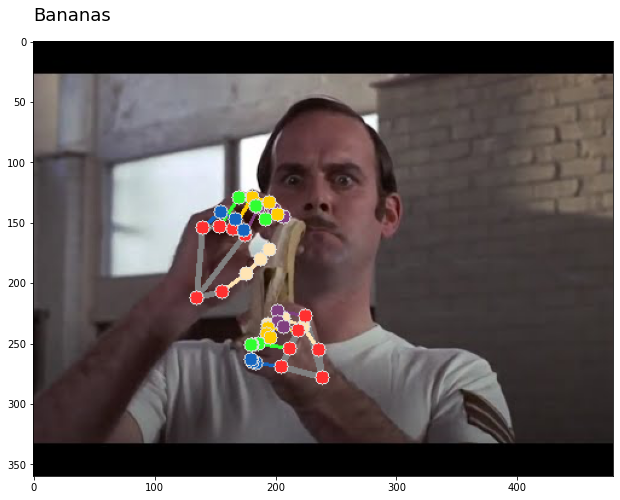

In [15]:
image = IMAGES['banana'].copy()
scan_hands(image, plot_image=True, plot_3D_model=True, image_title='Bananas')

### Multiple Images


Classification results for ednaldo
[classification {
  index: 0
  score: 0.9968498349189758
  label: "Left"
}
]
Left Hand index fingertip coordinate: (116.12, 152.69)

Classification results for banana
[classification {
  index: 1
  score: 0.9913330674171448
  label: "Right"
}
, classification {
  index: 0
  score: 0.9969881772994995
  label: "Left"
}
]
Right Hand index fingertip coordinate: (272.52, 145.92)
Left Hand index fingertip coordinate: (272.91, 236.64)

Classification results for kira
[classification {
  index: 0
  score: 0.9796077609062195
  label: "Left"
}
, classification {
  index: 1
  score: 0.9313183426856995
  label: "Right"
}
]
Left Hand index fingertip coordinate: (298.09, 372.34)
Right Hand index fingertip coordinate: (87.25, 199.98)

Classification results for hands
[classification {
  index: 0
  score: 0.9790897369384766
  label: "Left"
}
, classification {
  index: 1
  score: 0.958825945854187
  label: "Right"
}
]
Left Hand index fingertip coordinate: (4715.00, 

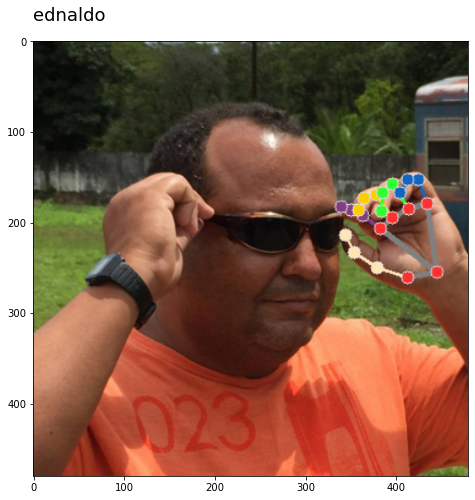

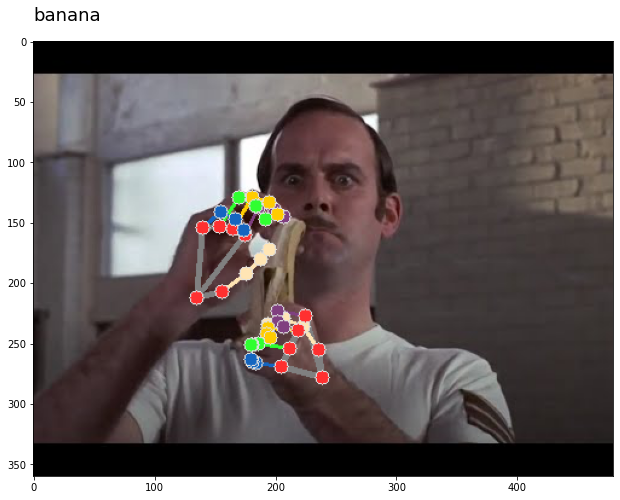

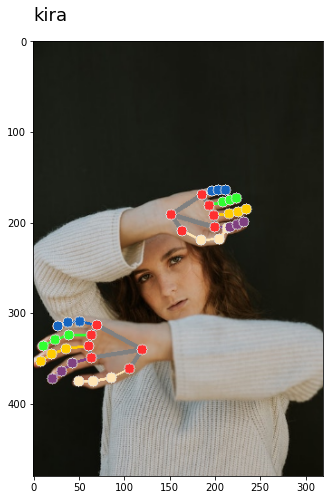

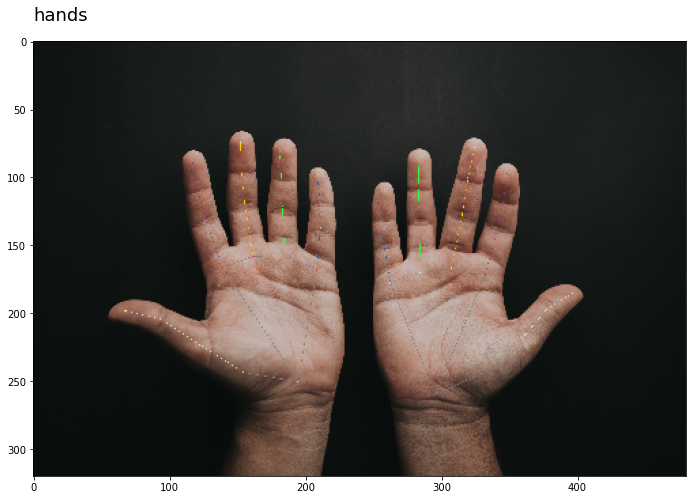

In [16]:
for image_name in IMAGES:
    image = IMAGES[image_name].copy()
    scan_hands(image, plot_image=True, image_title=image_name)

## Webcam Test

In [70]:
# Webcam input
cam = cv2.VideoCapture(0)

hands = mp_hands.Hands(model_complexity=0, min_detection_confidence=0.5, min_tracking_confidence=0.9)

while cam.isOpened():
    success, image = cam.read()
    if not success:
        print("Ignoring empty camera frame.")
        # If loading a video, use 'break' instead of 'continue'.
        continue

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Draw the hand annotations on the image.
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                image, hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style())
            
    # Flip the image horizontally for a selfie-view display.
    cv2.imshow('MediaPipe Hands', cv2.flip(image, 1))
    # Use ESC key to close webcam
    if cv2.waitKey(5) & 0xFF == 27:
        break

# Release video capture
cam.release()
# Memory dump
cv2.destroyAllWindows()
# fix window not closing bug on macOS 10.15
cv2.waitKey(1)

-1

## Speaker test in Static Image

Testing `osascript`

In [18]:
set_system_volume(50, True)
time.sleep(3)
set_system_volume(25, True)

Volume changed from 23 to 50.0
Volume changed from 50 to 25.0


Processing image an extracting results

In [90]:
# Get image
image = IMAGES['banana'].copy()
# Create mediapipe Hands object
hands = mp_hands.Hands(model_complexity=0, min_detection_confidence=0.5, min_tracking_confidence=0.5)
# Process image
hand_map = hand_detection(image, hands)
# Check if both hands were detected
hand_map.keys()

dict_keys(['Right', 'Left'])

Select the points that will control volume range

In [31]:
finger_1 = hand_map['Right']['THUMB_TIP']
finger_2 = hand_map['Right']['INDEX_FINGER_TIP']
finger_1, finger_2

((288, 151), (274, 142))

Calculate distance between them

In [34]:
finger_distance = get_points_distance(finger_1, finger_2)
finger_distance

16.64331697709324

Apply volume change

In [35]:
set_system_volume(finger_distance, True)

Volume changed from 6 to 16.6


Now let's wrap everything and test in a live video

## Controlling sytem volume with Webcam

In [ ]:
# Webcam input
cam = cv2.VideoCapture(0)

# Volume sensitivity 
VOLUME_SENSITIVITY = 0.3

# Create mediapipe Hands object
hands = mp_hands.Hands(model_complexity=0, min_detection_confidence=0.8, min_tracking_confidence=0.9)

# Webcam is running
while cam.isOpened():
    # If loading a video, use 'break' instead of 'continue'
    success, image = cam.read()
    if not success:
        print("Ignoring empty camera frame.")
        continue
    # Improve performance = False
    image.flags.writeable = True
    # Flip the image horizontally for a selfie-view display.
    image = cv2.flip(image, 1)
    # Get image dimensions
    h, w, _ = image.shape
    # process image
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # instance hand map
    hand_map = {}
       
    if results.multi_hand_landmarks:
        for index, hand_landmarks in enumerate(results.multi_hand_landmarks):
            # Draw the hand annotations on the image. 
            draw_landmarks(image, hand_landmarks, HAND_CONNECTIONS)
            # Get current hand str
            current_hand = get_current_hand(results.multi_handedness[index])
            # Get current hand points coordinates
            hand_position = find_hand_position(image, hand_landmarks)
            # Store values
            hand_map[current_hand] = map_hand_coord(hand_position)

            # Change volume
            if 'Left' in hand_map.keys():
                # Select fingers
                finger_1 = hand_map['Left']['THUMB_TIP']
                finger_2 = hand_map['Left']['INDEX_FINGER_TIP']
                # Calculate distante and draw in frame
                finger_distance = get_points_distance(finger_1, finger_2, draw_points=True)
                # Bar position
                tx, ty = int(w*0.05), int(h*0.15) # top    x, y coord
                bx, by = int(w*0.08), int(h*0.35) # bottom x, y coord
                hand_screen_range = [int(h*0.05), int(h*0.40)] # 3 - 40 % of screen height
                volume_range = [0, 100]  # System volume range
                bar_range = [by, ty]     # Bar full range in screen
                # True value for volume level
                volume_level = np.interp(finger_distance, hand_screen_range, volume_range)
                bar_level = np.interp(volume_level, volume_range, bar_range)
                
                # Draw volume bar
                ## Empty bar (0,200,235) (198,138,9)
                cv2.rectangle(image, (tx, ty), (bx, by),
                              (20, 20, 20), -1)
                ## Filling bar
                cv2.rectangle(image,
                              (tx, int(bar_level)),
                              (bx, by),
                              (240, 240, 240), cv2.FILLED)
                ## Volume text
                cv2.putText(image,
                            f'{int(volume_level)}%', 
                            (tx-10, ty-10), 
                            cv2.FONT_ITALIC,1 , (240, 240, 240), 2)
            
                # Change system volume level
                set_system_volume(volume_level)
            
    # Show video
    cv2.imshow('MediaPipe Hands', image)
    # Use ESC key to close webcam
    if cv2.waitKey(5) & 0xFF == 27:
        break

# Release video capture
cam.release()
# Memory dump
cv2.destroyAllWindows()
# fix window not closing bug on macOS 10.15
cv2.waitKey(1)

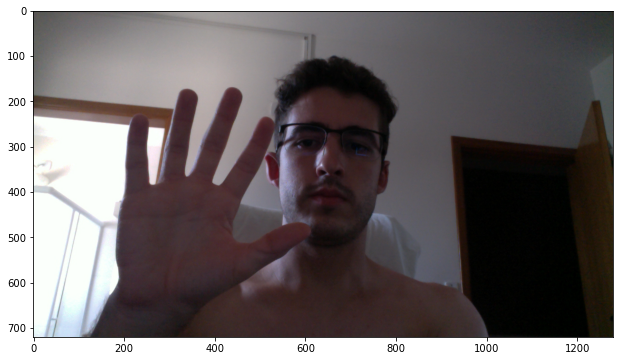

In [75]:
plt.figure(figsize=(12,6))
plt.imshow(cv2.flip(cv2.cvtColor(image, cv2.COLOR_BGR2RGB),1));

In [ ]:
h, w, _ = image.shape

In [76]:
h, w, _ = image.shape
# process image
results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# instance hand map
hand_map = {}

if results.multi_hand_landmarks:
    for index, hand_landmarks in enumerate(results.multi_hand_landmarks):
        # Draw the hand annotations on the image. 
        #draw_landmarks(image, hand_landmarks, HAND_CONNECTIONS)
        # Get current hand str
        current_hand = get_current_hand(results.multi_handedness[index])
        # Get current hand points coordinates
        hand_position = find_hand_position(image, hand_landmarks)
        # Store values
        hand_map[current_hand] = map_hand_coord(hand_position)

In [78]:
hand_position

[[0, 999, 626],
 [1, 905, 612],
 [2, 813, 560],
 [3, 745, 514],
 [4, 686, 489],
 [5, 865, 431],
 [6, 814, 350],
 [7, 786, 297],
 [8, 761, 251],
 [9, 919, 406],
 [10, 881, 307],
 [11, 857, 244],
 [12, 836, 192],
 [13, 979, 405],
 [14, 964, 307],
 [15, 953, 245],
 [16, 937, 193],
 [17, 1043, 425],
 [18, 1051, 348],
 [19, 1051, 300],
 [20, 1045, 256]]

**Note**: `osascript` package is just an quick alternative for macOS, and doesn't show a good performance in live video like `pycaw`.

In [157]:
# Run the code below if the window froze in the last cell
# cam.release()
# cv2.destroyAllWindows()
# cv2.waitKey(1)

## Text to Speech

**Speech engines for `pyttsx3`**
- macOs: nsss
- Linux: espeak
- Windows: sapi5  
  
**OBS:** `pyttsx3` is not suited for running in Jupyter Notebooks, so depending on which OS you are running, some bugs may occur

### Build pyttsx3 engine

In [4]:
engine = pyttsx3.init('nsss')

# Check properties
print('Engine properties')
for property in ['rate', 'voice', 'volume']:
    print(f'{property}: ', engine.getProperty(property))

Engine properties
rate:  200.0
voice:  com.apple.speech.synthesis.voice.Alex
volume:  1.0


### Checking all the voices available

In [5]:
voices = engine.getProperty('voices')
for voice in voices:
    print(f'{GREEN}Name:{WHITE} {voice.name}\t{GREEN}Language:{WHITE} {voice.languages}')

Name: Alex	Language: ['en_US']
Name: Alice	Language: ['it_IT']
Name: Alva	Language: ['sv_SE']
Name: Amelie	Language: ['fr_CA']
Name: Anna	Language: ['de_DE']
Name: Carmit	Language: ['he_IL']
Name: Damayanti	Language: ['id_ID']
Name: Daniel	Language: ['en_GB']
Name: Diego	Language: ['es_AR']
Name: Ellen	Language: ['nl_BE']
Name: Fiona	Language: ['en-scotland']
Name: Fred	Language: ['en_US']
Name: Ioana	Language: ['ro_RO']
Name: Joana	Language: ['pt_PT']
Name: Jorge	Language: ['es_ES']
Name: Juan	Language: ['es_MX']
Name: Kanya	Language: ['th_TH']
Name: Karen	Language: ['en_AU']
Name: Kyoko	Language: ['ja_JP']
Name: Laura	Language: ['sk_SK']
Name: Lekha	Language: ['hi_IN']
Name: Luca	Language: ['it_IT']
Name: Luciana	Language: ['pt_BR']
Name: Maged	Language: ['ar_SA']
Name: Mariska	Language: ['hu_HU']
Name: Mei-Jia	Language: ['zh_TW']
Name: Melina	Language: ['el_GR']
Name: Milena	Language: ['ru_RU']
Name: Moira	Language: ['en_IE']
Name: Monica	Language: ['es_ES']
Name: Nora	Language: ['n

### Change properties

In [6]:
engine.setProperty('voice', voices[0].id)
engine.setProperty('volume', 0.5)

### Properties summary

In [7]:
def engine_summary(engine):
    print(f'{GREEN}Engine properties{WHITE}')
    for voice in engine.getProperty('voices'):
        if voice.id == engine.getProperty('voice'):
            print('Name:', voice.name)
            print('Language:', voice.languages)  
    print('Voice ID:', engine.getProperty('voice'))
    print('Rate:', engine.getProperty('rate'))
    print('Volume:', engine.getProperty('volume'))

In [8]:
engine_summary(engine)

Engine properties
Name: Alex
Language: ['en_US']
Voice ID: com.apple.speech.synthesis.voice.Alex
Rate: 200.0
Volume: 1.0


### Create functions

In [19]:
# Read text and speak
def speak(audio, engine):
    engine.say(audio)
    engine.runAndWait()

In [10]:
# Read text from file
def speak_file(file_name, engine, preview_audio=-1, verbose=True):
    with open(file_name, 'r', encoding='utf8') as file:
        for line in file.readlines(preview_audio):
            if verbose: print(line)
            speak(line, engine)

In [50]:
# Read text from file and output in wav format
def text_file_to_audio(input_file, output_file, engine, enc='utf8', 
                       line_delimiter=', ', verbose=False):
    with open(input_file, 'r', encoding=enc) as file:
        print('Saving file...')
        full_text = line_delimiter.join(file.readlines())
        if verbose: print(full_text)
        engine.save_to_file(full_text, output_file)
        print(f'File saved in {os.getcwd()+"/"+output_file}.')

In [12]:
def get_language_index(language, engine, verbose=False):
    # Get voices available
    voices = engine.getProperty('voices')
    
    languages = {}
    
    # Search for the desired language
    for index, voice in enumerate(voices):
        if language in voice.languages:
            languages[voice.name] = index
            if verbose:
                print(f'Name: {voice.name}\tIndex: {index}')
    if languages:
        return languages
    else:
        print(f'Language {language} not found.')

In [13]:
def voice_sound_test(languages, engine, default_text='One does not simply walk into mordor'):
    
    voices = engine.getProperty('voices')
    
    print(f'Text: {default_text}')
    for name, index in languages.items():
        print(f'Playing voice of {name} [{index}]')
        engine.setProperty('voice', voices[index].id)
        engine.setProperty('volume', 0.5)
        speak(default_text, engine)

In [16]:
# Test sound
speak('Potato', engine)

### Read text in EN-US

In [17]:
# Create a new engine
en_engine = pyttsx3.init('nsss')
# Check available languages in en_US
en_voices = get_language_index('en_US', en_engine, verbose=True)

Name: Alex	Index: 0
Name: Fred	Index: 11
Name: Samantha	Index: 33
Name: Victoria	Index: 41


In [20]:
# Play sound test for each voice
voice_sound_test(en_voices, pyttsx3.init('nsss'))

Text: One does not simply walk into mordor
Playing voice of Alex [0]
Playing voice of Fred [11]
Playing voice of Samantha [33]
Playing voice of Victoria [41]


In [21]:
# Change settings
en_engine.setProperty('voice', voices[en_voices['Alex']].id)
en_engine.setProperty('volume', 0.5)
en_engine.setProperty('rate', 175)
# Test sound
speak('Potato', en_engine)

In [22]:
# View engine summary
engine_summary(en_engine)

Engine properties
Name: Alex
Language: ['en_US']
Voice ID: com.apple.speech.synthesis.voice.Alex
Rate: 175.0
Volume: 0.5


In [20]:
file_name = 'data/en_us_lyrics_preview.txt'
speak_file(file_name, en_engine)

Some things in life are bad

They can really make you mad

Other things just make you swear and curse

When you're chewing on life's gristle

Don't grumble, give a whistle

And this'll help things turn out for the best

And

Always look on the bright side of life

Always look on the light side of life



Save audio to file in `wav` format

In [23]:
file_name = 'data/en_us_lyrics_full.txt'
output_file = 'data/brian.wav'
text_file_to_audio(file_name, output_file, en_engine)

Saving file...
File saved in /Users/baiochi/OneDrive/GitHub/LetsCode/7_Unstructured_Data/Exercicesdata/brian.wav.


### Read text in PT-BR

Change engine to speak **PT-BR**

In [24]:
# Check available languages in en_US
br_engine = pyttsx3.init('nsss')
pt_BR_voices = get_language_index('pt_BR', br_engine, verbose=True)

Name: Luciana	Index: 22


In [45]:
# Change settings
br_engine.setProperty('voice', voices[pt_BR_voices['Luciana']].id)
br_engine.setProperty('volume', 0.5)
br_engine.setProperty('rate', 190)
# Test sound
speak('Você gosta mais de batata ou de estudar?', br_engine)

In [31]:
# View engine summary
engine_summary(br_engine)

Engine properties
Name: Luciana
Language: ['pt_BR']
Voice ID: com.apple.speech.synthesis.voice.luciana.premium
Rate: 225.0
Volume: 0.5


In [47]:
speak_file('data/pt_br_lyrics_preview.txt', br_engine)

Evil Papagali, he wants to kill

He ordered me to puta que pariu

Evil Papagali, he is animal

He's got the power of heavy metal



Lôro

Lôro quer biscoito!

Lôro

Lôro quer biscoito!

Quer biscoito!


Save audio to file in `wav` format

In [51]:
file_name = 'data/pt_br_lyrics_full.txt'
output_file = 'data/massacration.wav'
text_file_to_audio(file_name, output_file, br_engine, enc='utf8')

Saving file...
File saved in /Users/baiochi/OneDrive/GitHub/LetsCode/7_Unstructured_Data/Exercices/data/massacration.wav.
